<div>
<img src="https://drive.google.com/uc?export=view&id=1vK33e_EqaHgBHcbRV_m38hx6IkG0blK_" width="350"/>
</div> 

#**Artificial Intelligence - MSc**
##ET5003 - MACHINE LEARNING APPLICATIONS 

###Instructor: Enrique Naredo
###ET5003_Lab_Piecewise_Regression

# INTRODUCTION

**Piecewise regression**, extract from [Wikipedia](https://en.wikipedia.org/wiki/Segmented_regression):

Segmented regression, also known as piecewise regression or broken-stick regression, is a method in regression analysis in which the independent variable is partitioned into intervals and a separate line segment is fit to each interval. 

* Segmented regression analysis can also be performed on 
multivariate data by partitioning the various independent variables. 
* Segmented regression is useful when the independent variables, clustered into different groups, exhibit different relationships between the variables in these regions. 

* The boundaries between the segments are breakpoints.

* Segmented linear regression is segmented regression whereby the relations in the intervals are obtained by linear regression. 

## Imports

In [1]:
import pandas as pd
import numpy as np
import pymc3 as pm
import arviz as az
import theano

from sklearn.preprocessing import StandardScaler

# to plot
import matplotlib.pyplot as plt
import matplotlib.colors
from mpl_toolkits.mplot3d import Axes3D
from jupyterthemes import jtplot

jtplot.style()

# to generate classification, regression and clustering datasets
import sklearn.datasets as datasets

# to create data frames
from pandas import DataFrame

# to generate data from an existing dataset
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

print(f"pymc3 version: {pm.__version__}")
print(f"arviz version: {az.__version__}")
print(f"theano version: {theano.__version__}")
!python --version
%load_ext lab_black

pymc3 version: 3.8
arviz version: 0.10.0
theano version: 1.0.4
Python 3.8.11


In [2]:
# Define the seed so that results can be reproduced
seed = 11
rand_state = 11

# Define the color maps for plots
color_map = plt.cm.get_cmap("RdYlBu")
color_map_discrete = matplotlib.colors.LinearSegmentedColormap.from_list(
    "", ["red", "cyan", "magenta", "blue"]
)

# DATASET

## Synthetic Dataset


**Synthetic data** plays a very important role in data science, allows us to test a new algorithm under controlled conditions, we can generate data that tests a very specific property or behavior of our algorithm.

* We can test its performance on balanced vs. imbalanced datasets.
* We can evaluate its performance under different noise levels.
* We can establish a baseline of our algorithm's performance under various scenarios.

Real data may be hard or expensive to acquire, or it may have too few data-points. 

Another reason is privacy, where real data cannot be revealed to others.

### Synthetic Data for Regression

The sklearn.datasets package has functions for generating synthetic datasets for regression. 

The make_regression() function returns a set of input data points (regressors) along with their output (target). 

This function can be adjusted with the following parameters:

    n_features - number of dimensions/features of the generated data
    noise - standard deviation of gaussian noise
    n_samples - number of samples

* The response variable is a linear combination of the generated input set.

* A response variable is something that's dependent on other variables.

* In this particular case, it is a target feature that we're trying to predict using all the other input features.


### Example

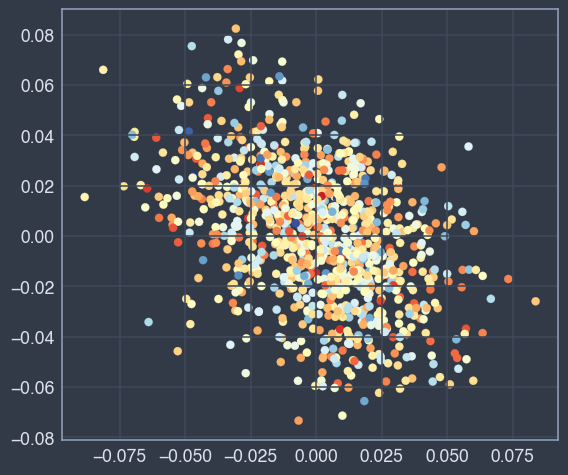

In [3]:
## Example
# data with just 2 features
X1, y1 = datasets.make_regression(
    n_samples=1000, n_features=2, noise=50, random_state=rand_state, effective_rank=1
)

scatter_plot2 = plt.scatter(
    X1[:, 0], X1[:, 1], c=y1, vmin=min(y1), vmax=max(y1), s=35, cmap=color_map
)
plt.show()

### Create Synthetic Data

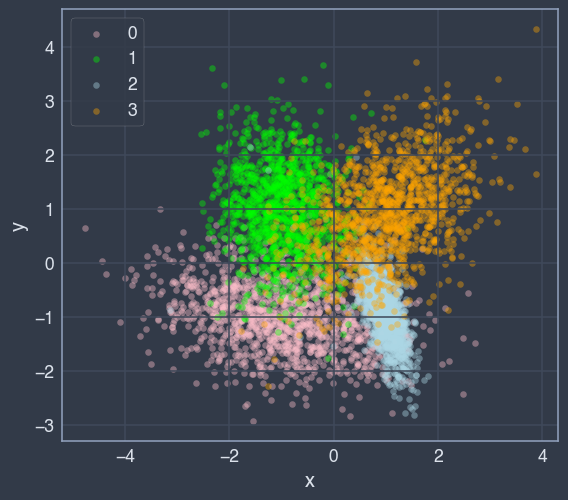

In [4]:
# create random datw with 4 clusters

num_samples = 5000
X2, y2 = datasets.make_classification(
    n_classes=4,
    n_features=2,
    n_samples=num_samples,
    n_redundant=0,
    n_informative=2,
    n_clusters_per_class=1,
)


# create a data frame
df = DataFrame(dict(x=X2[:, 0], y=X2[:, 1], label=y2))

fig, ax = plt.subplots()
colors = {0: "pink", 1: "lime", 2: "lightblue", 3: "orange"}
grouped = df.groupby("label")

# scatter plot
for key, group in grouped:
    group.plot(
        ax=ax, kind="scatter", x="x", y="y", label=key, color=colors[key], alpha=0.4
    )
# show the plot
plt.show()

In [5]:
## Main dataset with 4 features
# we'll use this dataset

X3, y3 = datasets.make_regression(
    n_samples=num_samples,
    n_features=4,
    n_informative=4,
    noise=0.2,
    random_state=rand_state,
)
print(X3.shape, y3.shape)

(5000, 4) (5000,)


In [6]:
# intervals to scale features
scaleX0 = (50, 60)
scaleX1 = (4, 7)
scaleX2 = (1, 2)
scaleX3 = (450, 710)
scaleX4 = (30, 5000)
scaleX5 = (10, 800)
scaleY = (150000, 2000000)

# Scale features
f0 = np.interp(X2[:, 0], (X2[:, 0].min(), X2[:, 0].max()), scaleX0)
f1 = np.interp(X2[:, 1], (X2[:, 1].min(), X2[:, 1].max()), scaleX1)
f2 = np.interp(X3[:, 0], (X3[:, 0].min(), X3[:, 0].max()), scaleX2)
f3 = np.interp(X3[:, 1], (X3[:, 1].min(), X3[:, 1].max()), scaleX3)
f4 = np.interp(X3[:, 2], (X3[:, 2].min(), X3[:, 2].max()), scaleX4)
f5 = np.interp(X3[:, 3], (X3[:, 3].min(), X3[:, 3].max()), scaleX5)

# scaled data
X = np.stack((f0, f1, f2, f3, f4, f5), axis=1)
y = np.interp(y3, (y3.min(), y3.max()), scaleY)

print(X.shape, y.shape)

(5000, 6) (5000,)


## Training & Test Data

In [7]:
# split data into training and test
from sklearn.model_selection import train_test_split

# training: 70% (0.7), test: 30% (0.3)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [8]:
def replace_with_nan(df, frac):
    """Replace some values randomly with nan"""
    rows = np.random.choice(range(df.shape[0]), int(df.shape[0] * frac), replace=False)
    cols = np.random.choice(range(0, df.shape[1] - 1), size=len(rows), replace=True)
    to_repl = [np.nan for i, col in zip(rows, cols)]

    # method used to cast a pandas object to a specified dtype
    rnan = df.to_numpy()
    rnan[rows, cols] = to_repl

    return DataFrame(rnan, index=df.index, columns=df.columns)

### Train dataset

In [9]:
## create train data frame
# use meaningful names
dftrain = DataFrame(
    dict(
        feature_1=X_train[:, 0],
        feature_2=X_train[:, 1],
        feature_3=X_train[:, 2],
        feature_4=X_train[:, 3],
        feature_5=X_train[:, 4],
        feature_6=X_train[:, 5],
        cost=y_train,
    )
)

In [10]:
# dftrain with nans
dftrain = replace_with_nan(dftrain, 0.10)
print("Number of nan in train dataset: ", dftrain.isnull().sum().sum())

Number of nan in train dataset:  350


In [11]:
# show first data frame rows
dftrain.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,cost
0,54.049780,4.476629,1.493103,563.452559,1968.298709,470.896770,9.652316e+05
1,52.635906,4.785852,1.644436,518.244737,2871.906637,423.850786,1.188102e+06
2,52.866130,4.914838,1.468078,596.792606,2017.226097,438.446029,9.945529e+05
3,55.105644,5.586502,1.576594,565.303882,1868.546868,383.827819,9.877374e+05
4,53.816079,5.161857,1.687612,580.287819,2087.434718,NaN,9.678723e+05


In [12]:
# Generate descriptive statistics
dftrain.describe()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,cost
count,3437.000000,3460.000000,3429.000000,3454.000000,3439.000000,3431.000000,3.500000e+03
mean,55.523285,5.197927,1.540578,560.860868,2409.047279,410.403845,1.058563e+06
std,1.478392,0.496657,0.125611,31.396063,695.045316,116.546671,2.326678e+05
min,50.000000,4.000000,1.120666,450.000000,30.000000,10.000000,1.500000e+05
25%,54.368996,4.792651,1.452869,540.171042,1942.709157,333.365777,8.999947e+05
50%,55.772777,5.123885,1.537470,561.284924,2402.512631,411.587807,1.061170e+06
75%,56.699250,5.597498,1.628738,581.189085,2891.414117,485.931388,1.215532e+06
max,59.997662,6.702121,1.963083,710.000000,5000.000000,800.000000,2.000000e+06


### Test dataset

In [13]:
## create test data frame
# no cost included

dftest = DataFrame(
    dict(
        feature_1=X_test[:, 0],
        feature_2=X_test[:, 1],
        feature_3=X_test[:, 2],
        feature_4=X_test[:, 3],
        feature_5=X_test[:, 4],
        feature_6=X_test[:, 5],
    )
)

In [14]:
# dftrain with nans
dftest = replace_with_nan(dftest, 0.10)
print("Number of nan in test dataset: ", dftest.isnull().sum().sum())

Number of nan in test dataset:  150


### Expected Cost dataset

In [15]:
## create expected cost data frame
# the cost is in another file
dfcost = DataFrame(dict(cost=y_test))
# show first data frame rows
dfcost.head()

,cost
0,5.815654e+05
1,8.599849e+05
2,9.735871e+05
3,1.039287e+06
4,1.041739e+06


In [16]:
# Generate descriptive statistics
dfcost.describe()

,cost
count,1.500000e+03
mean,1.054827e+06
std,2.318753e+05
min,3.936376e+05
25%,9.011287e+05
50%,1.059186e+06
75%,1.209562e+06
max,1.936235e+06


## Save dataset

You can save your datataset in any location suitable for you, one choice using Colab is to save it in your Google Drive this way you will have it handy for your experiments.

In [17]:
#  create a directory (if not exist)
import os


folderName = "synth_data"
syntPath = os.path.join(os.getcwd(), folderName)

if os.path.exists(syntPath):
    print(folderName, " directory already exists")
else:
    # create a directory
    os.mkdir(syntPath)
    print("Now you have a new directory: ", folderName)

synth_data  directory already exists


In [18]:
# manage versions if you like to save more datasets
# syntTrain1.csv, syntTrain2.csv, etc

## save train dataset into your Drive
filename1 = "train.csv"
dftrain.to_csv(syntPath + filename1, encoding="utf-8", index=False)

# save test dataset into your Drive
filename2 = "test.csv"
dftest.to_csv(syntPath + filename2, encoding="utf-8", index=False)

# save cost dataset into your Drive
filename3 = "coost.csv"
dfcost.to_csv(syntPath + filename3, encoding="utf-8", index=False)

## Load your dataset

In [19]:
training_file = syntPath + filename1
testing_file = syntPath + filename2
cost_file = syntPath + filename3

df_train = pd.read_csv(training_file)
df_test = pd.read_csv(testing_file)
df_cost = pd.read_csv(cost_file)

# PIECEWISE REGRESSION

## Full Model

In [20]:
# select some features columns just for the baseline model
# assume not all of the features are informative or useful
# in this exercise you could try all of them

feat_train = ["feature_1", "feature_2", "feature_3", "cost"]
# dropna: remove missing values
df_subset_train = df_train[feat_train].dropna(axis=0)

feat_test = ["feature_1", "feature_2", "feature_3"]
df_subset_test = df_test[feat_test].dropna(axis=0)

# cost
df_cost = df_cost[df_cost.index.isin(df_subset_test.index)]

In [21]:
print(
    "Number of nan in df_subset_train dataset: ", df_subset_train.isnull().sum().sum()
)
print("Number of nan in df_subset_test dataset: ", df_subset_test.isnull().sum().sum())

Number of nan in df_subset_train dataset:  0
Number of nan in df_subset_test dataset:  0


In [22]:
# train set, input columns
Xs_train = df_subset_train.iloc[:, :-1].values
# train set, output column, cost
ys_train = df_subset_train.iloc[:, -1].values.reshape(-1, 1)

# test set, input columns
Xs_test = df_subset_test.iloc[:, 0:].values
# test set, output column, cost
y_test = df_cost.cost.values

In [23]:
# StandardScaler() will normalize the features i.e. each column of X,
# so, each column/feature/variable will have μ = 0 and σ = 1
scaler = StandardScaler()

X_train_poly_feat = np.hstack([Xs_train, Xs_train[:, [2]] ** 2])
X_train_poly_scaled = scaler.fit_transform(X_train_poly_feat)

X_test_poly_feat = np.hstack([Xs_test, Xs_test[:, [2]] ** 2])
X_test_poly_scaled = scaler.transform(X_test_poly_feat)

y_log = np.log(ys_train)
y_scaler = StandardScaler()
yn_train = y_scaler.fit_transform(y_log)

In [24]:
# model
with pm.Model() as model:
    # prior over the parameters of linear regression
    alpha = pm.Normal("alpha", mu=0, sigma=30)
    # we have one beta for each column of Xn
    beta = pm.Normal("beta", mu=0, sigma=30, shape=X_train_poly_scaled.shape[1])
    # linear regression model in matrix form
    mu = alpha + pm.math.dot(beta, X_train_poly_scaled.T)

    # prior over the variance of the noise
    sigma = pm.HalfCauchy("sigma_n", 5)
    # likelihood, be sure that observed is a 1d vector
    like = pm.Normal("likelihood", mu=mu, sigma=sigma, observed=yn_train[:, 0])

WARNING (theano.gof.compilelock): Overriding existing lock by dead process '51358' (I am process '4176')


Average Loss = 3,834.5: 100%|██████████| 30000/30000 [00:14<00:00, 2079.42it/s]
Finished [100%]: Average Loss = 3,834.5


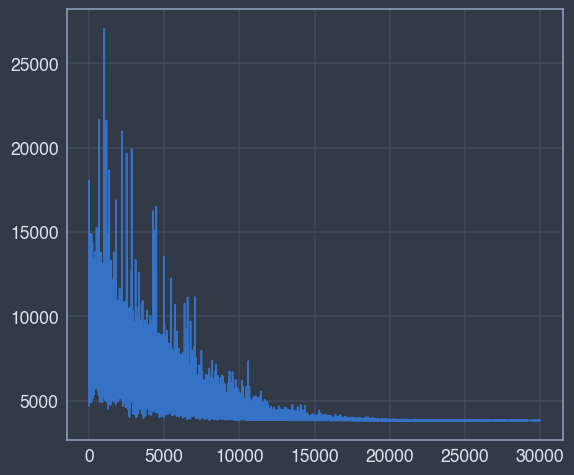

In [25]:
# https://stackoverflow.com/questions/51238578/error-non-constant-expression-cannot-be-narrowed-from-type-npy-intp-to-int
theano.config.gcc.cxxflags = "-Wno-c++11-narrowing"

# number of iterations of the algorithm
iterations = 30000

# run the model
with model:
    approximation = pm.fit(iterations, method="advi")

# check the convergence
plt.plot(approximation.hist)
plt.show()

In [26]:
# samples from the posterior
posterior = approximation.sample(5000)

In [27]:
# prediction
log_likelihood = np.mean(posterior["alpha"]) + np.dot(
    np.mean(posterior["beta"], axis=0), X_test_poly_scaled.T
)
y_pred_BLR = np.exp(y_scaler.inverse_transform(log_likelihood.reshape(-1, 1)))[:, 0]
print("MAE = ", (np.mean(abs(y_pred_BLR - y_test))))
print("MAPE = ", (np.mean(abs(y_pred_BLR - y_test) / y_test)))

MAE =  144164.944188865
MAPE =  0.14611926716142742


## Clustering

### Full Model

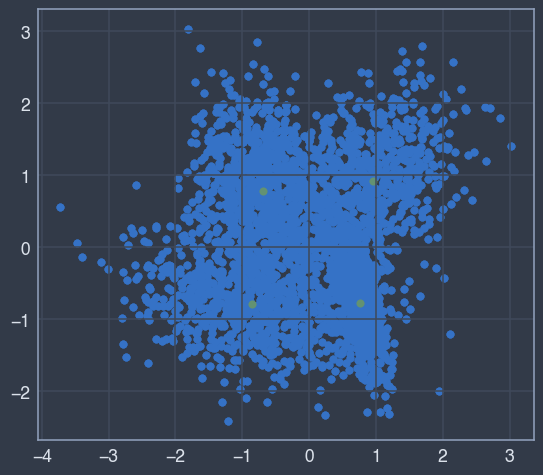

In [28]:
# training gaussian mixture model
from sklearn.mixture import GaussianMixture

n_clusters = 4
gmm = GaussianMixture(n_components=n_clusters)
# clustering by features 1, 2
ind = [0, 1]
X_ind = np.vstack([X_train_poly_scaled[:, ind], X_train_poly_scaled[:, ind]])
# Gaussian Mixture
gmm.fit(X_ind)
# plot blue dots
plt.scatter(X_ind[:, 0], X_ind[:, 1])
# centroids:  orange dots
plt.scatter(gmm.means_[:, 0], gmm.means_[:, 1], alpha=0.6)
plt.show()

### Clusters

In [29]:
# train clusters
train_clusters = gmm.predict(X_train_poly_scaled[:, ind])
unique_train, counts_train = np.unique(train_clusters, return_counts=True)
dict(zip(unique_train, counts_train))

{0: 923, 1: 798, 2: 964, 3: 641}

In [30]:
# test clusters
test_clusters = gmm.predict(X_test_poly_scaled[:, ind])
unique_test, counts_test = np.unique(test_clusters, return_counts=True)
dict(zip(unique_test, counts_test))

{0: 394, 1: 331, 2: 391, 3: 298}

In [31]:
X_train_clusters = []
X_test_clusters = []
y_train_clusters = []
scaler = StandardScaler()

for k in range(n_clusters):
    X_train_clusters.append(X_train_poly_scaled[train_clusters == k, :])
    X_test_clusters.append(X_test_poly_scaled[test_clusters == k, :])

    y_train_clusters.append(
        scaler.fit_transform(np.log(ys_train[train_clusters == k, :]))
    )

## Piecewise Models

In [32]:
posteriors = []
for n in range(n_clusters):

    with pm.Model() as model:
        alpha = pm.Normal("alpha", mu=0, sigma=30)
        beta = pm.Normal("beta", mu=0, sigma=30, shape=X_train_clusters[n].shape[1])

        mu = alpha + pm.math.dot(beta, X_train_clusters[n].T)

        sigma = pm.HalfCauchy("sigma_n", 5)
        like = pm.Normal(
            "like", mu=mu, sigma=sigma, observed=y_train_clusters[n].ravel()
        )
        approximation = pm.fit(40000, method="advi")
        posteriors.append(approximation.sample(5000))

Average Loss = 1,085.6: 100%|██████████| 40000/40000 [00:13<00:00, 3006.75it/s]
Finished [100%]: Average Loss = 1,085.6
Average Loss = 961.82: 100%|██████████| 40000/40000 [00:13<00:00, 2956.10it/s]
Finished [100%]: Average Loss = 961.82
Average Loss = 1,102.8: 100%|██████████| 40000/40000 [00:14<00:00, 2724.96it/s]
Finished [100%]: Average Loss = 1,102.8
Average Loss = 789.25: 100%|██████████| 40000/40000 [00:13<00:00, 3063.45it/s]
Finished [100%]: Average Loss = 789.25


In [33]:
# Posterior predictive checks (PPCs)
def ppc(alpha, beta, sigma, X, nsamples=500):
    # we select nsamples random samples from the posterior
    ind = np.random.randint(0, beta.shape[0], size=nsamples)
    alphai = alpha[ind]
    betai = beta[ind, :]
    sigmai = sigma[ind]

    Ypred = np.zeros((nsamples, X.shape[0]))
    for i in range(X.shape[0]):
        # we generate data from linear model
        y_pred = (
            alphai
            + np.dot(betai, X[i : i + 1, :].T).T
            + np.random.randn(len(sigmai)) * sigmai
        )
        Ypred[:, i] = y_pred[0, :]
    return Ypred

# Simulations

In [56]:
def plot_ppc(posterior, X, y, ax, remove_legend, n_samples=200):
    scaler = StandardScaler().fit(y)
    y_pred = scaler.inverse_transform(
        ppc(
            posterior["alpha"],
            posterior["beta"],
            posterior["sigma_n"],
            X,
            nsamples=n_samples,
        )
    )
    kwargs = dict(linewidth=0.2, alpha=0.3)
    for i in range(len(y_pred)):
        az.plot_dist(y_pred[i, :], color="lightblue", ax=ax, plot_kwargs=kwargs)
    az.plot_dist(
        y_pred[i, :],
        color="lightblue",
        ax=ax,
        plot_kwargs=kwargs,
        label="predictions",
    )
    kwargs.update({"linewidth": 0.9, "alpha": 0.8})
    az.plot_dist(
        y, ax=ax, color="#ff491c", label="true observations", plot_kwargs=kwargs
    )
    if remove_legend:
        ax.get_legend().remove()
    return y_pred

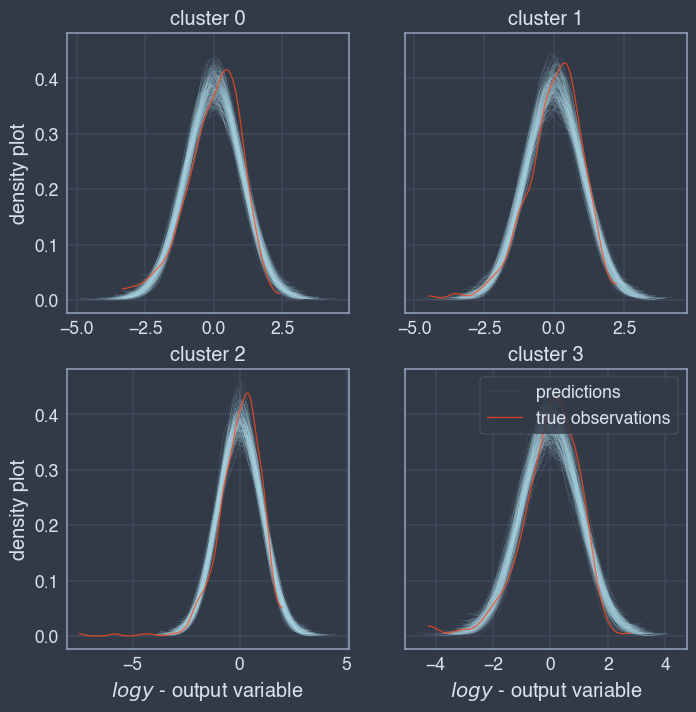

In [57]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8), sharex=False, sharey=True)
piecewise_ppc = []

for idx, ax in enumerate(axes.flatten()):
    remove_legend = True if idx != n_clusters - 1 else False
    piecewise_ppc.append(
        plot_ppc(
            posteriors[idx],
            X_train_clusters[idx],
            y_train_clusters[idx],
            ax,
            remove_legend,
        )
    )
    ax.set_title(f"cluster {idx}")
    if idx % 2 == 0:
        ax.set_ylabel("density plot")
    if idx > 1:
        ax.set_xlabel("$log{y}$ - output variable")

plt.show()

## Overall

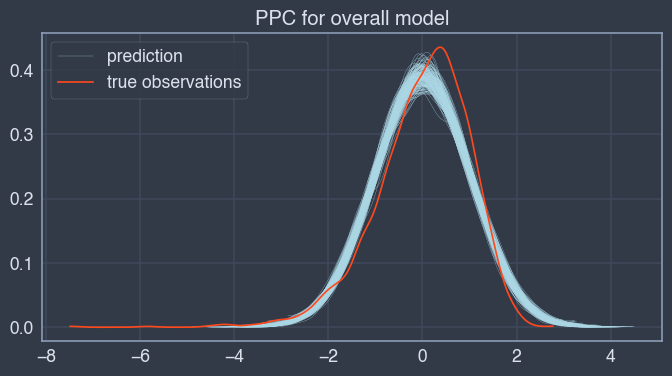

In [71]:
overall_ppc = [
    ppc(
        post["alpha"],
        post["beta"],
        post["sigma_n"],
        X_train_clusters[idx],
        nsamples=200,
    )
    for idx, post in enumerate(posteriors)
]

y_scalers = [scaler.fit(y_train_piece) for y_train_piece in y_train_clusters]
y_pred_overall = np.hstack(
    [
        y_scaler.inverse_transform(y_pred_piece)
        for y_scaler, y_pred_piece in zip(y_scalers, piecewise_ppc)
    ]
)

fig, ax = plt.subplots(figsize=(8, 4))

for idx in range(len(y_pred_overall)):
    az.plot_dist(
        y_pred_overall[idx, :],
        color="lightblue",
        plot_kwargs=dict(linewidth=0.2),
        ax=ax,
    )
az.plot_dist(
    y_pred_overall[idx, :],
    color="lightblue",
    plot_kwargs=dict(linewidth=0.2),
    label="prediction",
    ax=ax,
)

y_true_overall = np.vstack(y_train_clusters)
az.plot_dist(
    y_true_overall,
    ax=ax,
    color="#ff491c",
    label="true observations",
)
ax.set_title("PPC for overall model")
plt.show()

## Test set performance

In [82]:
joint_y_preds = []

for (X_test, y_scaler, posterior, idx) in zip(
    X_test_clusters, y_scalers, posteriors, range(n_clusters)
):
    y_test_pred = np.exp(
        y_scaler.inverse_transform(
            np.mean(posterior["alpha"])
            + np.dot(np.mean(posterior["beta"], axis=0), X_test.T)
        )
    )
    print(
        f"Size of cluster {idx}: {np.sum(test_clusters==idx)}, MAE= {np.mean(abs(y_test_pred - y_test[test_clusters==idx])):.3f}"
    )
    joint_y_preds.append(y_test_pred)

joint_y_preds = np.hstack(
    [
        abs(y_pred - y_test[test_clusters == idx])
        for idx, y_pred in enumerate(joint_y_preds)
    ]
)
print(f"Overall MAE= {np.mean(joint_y_preds):.3f}")

Size of cluster 0: 394, MAE= 1042042.374
Size of cluster 1: 331, MAE= 1057699.168
Size of cluster 2: 391, MAE= 1052963.629
Size of cluster 3: 298, MAE= 1070454.190
Overall MAE= 1054715.168


### PPC on the Test set



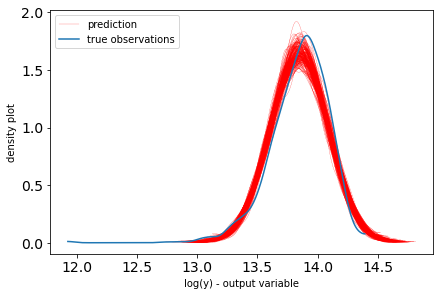

In [ ]:
## Posterior predictive checks (PPCs)

num_samples2 = 200
Ypred0 = ppc(posterior0['alpha'],posterior0['beta'],posterior0['sigma_n'],Xtestn0, nsamples=num_samples2)
Ypred1 = ppc(posterior1['alpha'],posterior1['beta'],posterior1['sigma_n'],Xtestn1, nsamples=num_samples2)
Ypred2 = ppc(posterior2['alpha'],posterior2['beta'],posterior2['sigma_n'],Xtestn2, nsamples=num_samples2)
Ypred3 = ppc(posterior3['alpha'],posterior3['beta'],posterior3['sigma_n'],Xtestn3, nsamples=num_samples2)

# Stack arrays in sequence horizontally (column wise)
Ypred = np.hstack([yscaler0.inverse_transform(Ypred0),
                 yscaler1.inverse_transform(Ypred1),
                 yscaler2.inverse_transform(Ypred2),
                 yscaler3.inverse_transform(Ypred3)])

# plot prediction shape
for i in range(Ypred.shape[0]):
    az.plot_dist( Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2})
# label
az.plot_dist(Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")

# true observations
az.plot_dist(np.log(y_test),label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");